#  Iterate Source Hosts, over time periods, to create an Analytical Data Set &nbsp;&nbsp; for the Out-Degree Entropy model

In [1]:
# use print only as a function
from __future__ import print_function
import sys
sys.version

'2.7.9 (default, Jun 29 2016, 13:08:31) \n[GCC 4.9.2]'

## Connect to data and read into dataframe

In [2]:
__author__ = 'swe03'

import numpy as np
import pandas as pd
import pandas.io.gbq as pdg
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
from decimal import *
import re 

import statsmodels.tsa as tsa

from statsmodels.tsa.stattools import ccf 
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.base import datetools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats.stats import pearsonr

from sklearn import linear_model

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from scipy import stats

from datetime import datetime, timedelta

desired_width = 250
pd.set_option('display.width',desired_width)
pd.set_option('display.max_rows', 500)

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Import the modules that do cell magics.
import datalab.bigquery.commands
import datalab.context.commands
import datalab.data.commands
#import datalab.stackdriver.commands
import datalab.storage.commands
import datalab.utils.commands

In [4]:
from StringIO import StringIO
import IPython.core.magic as magic
import datalab.utils.commands

###### Install the SQL package if not already installed 

In [5]:
#!pip install pandasql

In [6]:
from pandasql import PandaSQL 
pdsql = PandaSQL()

##### Use an existing table but change the timestamps to create a contiguous distribution.

In [7]:
def skip():  
  date_s = "2017-08-07 01:59:59"
  print('date_s= ',date_s)
  time_parts = date_s.split(" ")
  print("time_parts= ",time_parts )
  print('time_parts[1]',time_parts[1])
  hour,minute,sec = time_parts[1].split(":")
  print("hour= ",hour)
  print("minute= ",minute)

In [171]:
#########################################################
### Iterate through various date ranges to create the a timeframe sample for later aggregation
#########################################################
#########################################################
## For each of the 5 minute aggregations, the data is randomly distributed across the "parts".
#########################################################
def Get_recs_w_date_range(date_s):
    #global df_final   # Otherwise, df_final is considered Local and will not be global scope of the dataframe created above
    global bucket
    
    
    time_parts = date_s.split(" ")    ## First split the time from the date string
    hour,minute,sec = time_parts[1].split(":")    ## Then split the time components
    
    part_nbr = 0                # Initialize 
    while part_nbr <= 3:        # Number of parts is arbitrary since the data is distributed randomly (i.e., not time sequenced)
        part_nbr_s = str(part_nbr)
        part = "part-0000" + part_nbr_s 
        print('partition = ',part)
        bucket = "gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/" + hour + "/" + minute + "/" + part   
        print('bucket name = ',bucket)
        part_nbr = part_nbr + 1
        print('part_nbr =', part_nbr)

    return bucket         

In [172]:
def Initialize_and_Iterate():
  global date_start
  global df_final
  date_start_str = '2017-08-09 00:00:00'
  date_start = pd.to_datetime(date_start_str)            ## Must start on the GCS 5-min aggregate folder value (e.g., 00, 05, 10, etc.)
  date_end_interval   = pd.to_datetime('2017-08-09 23:55:00')   ## Must end on the GCS 5-min aggregate folder value (e.g., 23:00:00, 01:05:00)
  
  while date_start <= pd.to_datetime(date_end_interval):
    
    print('For get_recs function date_start=',date_start)
    
    Get_recs_w_date_range(date_start_str)  
    
    %storage read --object $bucket --variable data_var 
    df1 = pd.read_json(data_var,lines=True)                    # use the variable in the read_json function
    df1 = pdsql("""Select * from df1 where srcAd in 
    ('165.130.217.225','165.130.217.226','165.130.217.227','165.130.217.228','165.130.217.229','165.130.217.230','165.130.217.231',
     '165.130.217.232','165.130.217.233','165.130.217.234','165.130.217.235','165.130.217.236','165.130.217.237','165.130.217.238')""", locals()) 
    df_final = df_final.append(df1)  
    
    
    date_start = date_start + timedelta(minutes=5)           # Add 5 minutes to start datetime for the next set of 5-minute aggregates
    date_start_str = date_start.strftime('%Y-%m-%d %H:%M:%S')
    print("this is the date string",date_start_str)
  
  return    

In [80]:
def readgcs():
  %storage read --object $bucket --variable data_var 
  df1 = pd.read_json(data_var,lines=True)                    # use the variable in the read_json function
  df1 = pdsql("""Select * from df1 where srcAd in ("165.130.217.229", "165.130.217.228","165.130.217.225")""", locals()) 
  df_final = df_final.append(df1)  
  return

In [10]:
def skip():
  date_start = pd.to_datetime('2017-08-07 00:00:00')            ## Must start on the GCS 5-min aggregate folder value (e.g., 00, 05, 10, etc.)
  print("type is:",type(date_start))
  print("value = ",date_start)
  date_start_str = date_start.Timestamp.dt.strftime('%Y-%m-%d-%H')

In [126]:
def Create_date_hour():
  df_final.EventDT = pd.to_datetime(df_final.flStDttmEst)
  df_final['date_hour'] = df_final.EventDT.dt.strftime('%Y-%m-%d-%H')  # creates a Series with Date and Hour
  df_final['date_hour'] = pd.to_datetime(df_final['date_hour'] )
  #df_final.reset_index(drop=True, inplace=True)
  return 

In [12]:
def Write_to_gbq(addr_port_s):
  #model_addr_port = "'" + 'prod.' + addr_port_s + "'"
  model_addr_port = 'prod.' + addr_port_s  
  parm_str = pd.Series([model_addr_port]) 
  print("This is the parm str:",parm_str)
  
  pdg.to_gbq(dfx2, model_addr_port, "network-sec-analytics", verbose=True, reauth=False, 
   if_exists='replace', private_key=None)

  #dfx2.to_gbq(parm_str, "network-sec-analytics", verbose=True, reauth=False, 
   #if_exists='replace', private_key=None)
  return

### Initiate the Process

##### Call the functions

In [173]:
df_final = pd.DataFrame()            # Create the df that will be appended to for each timeframe
Initialize_and_Iterate()           # For each Host/Port, iterate through the timeframes 
Create_date_hour()                 # Create a Day/Hour variable for the final, appended df

For get_recs function date_start= 2017-08-09 00:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/00/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/00/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/00/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/00/00/part-00003
part_nbr = 4
this is the date string 2017-08-09 00:05:00
For get_recs function date_start= 2017-08-09 00:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/00/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/00/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/00/05/part-00002
part_nbr = 3
partition =  part-0000

Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/00/part-00003 does not exist


this is the date string 2017-08-09 16:00:00
For get_recs function date_start= 2017-08-09 16:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/00/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/05/part-00003 does not exist


this is the date string 2017-08-09 16:05:00
For get_recs function date_start= 2017-08-09 16:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/05/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/05/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/10/part-00003 does not exist


this is the date string 2017-08-09 16:10:00
For get_recs function date_start= 2017-08-09 16:10:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/10/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/10/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/10/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/10/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/15/part-00003 does not exist


this is the date string 2017-08-09 16:15:00
For get_recs function date_start= 2017-08-09 16:15:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/15/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/15/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/15/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/15/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/20/part-00003 does not exist


this is the date string 2017-08-09 16:20:00
For get_recs function date_start= 2017-08-09 16:20:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/20/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/20/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/20/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/20/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/25/part-00003 does not exist


this is the date string 2017-08-09 16:25:00
For get_recs function date_start= 2017-08-09 16:25:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/25/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/25/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/25/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/25/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/30/part-00003 does not exist


this is the date string 2017-08-09 16:30:00
For get_recs function date_start= 2017-08-09 16:30:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/30/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/30/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/30/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/30/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/35/part-00003 does not exist


this is the date string 2017-08-09 16:35:00
For get_recs function date_start= 2017-08-09 16:35:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/35/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/35/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/35/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/35/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/40/part-00003 does not exist


this is the date string 2017-08-09 16:40:00
For get_recs function date_start= 2017-08-09 16:40:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/40/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/40/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/40/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/40/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/45/part-00003 does not exist


this is the date string 2017-08-09 16:45:00
For get_recs function date_start= 2017-08-09 16:45:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/45/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/45/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/45/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/45/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/50/part-00003 does not exist


this is the date string 2017-08-09 16:50:00
For get_recs function date_start= 2017-08-09 16:50:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/50/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/50/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/50/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/50/part-00003
part_nbr = 4
this is the date string 2017-08-09 16:55:00
For get_recs function date_start= 2017-08-09 16:55:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/55/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/55/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/55/pa

Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/16/55/part-00003 does not exist


this is the date string 2017-08-09 17:00:00
For get_recs function date_start= 2017-08-09 17:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/00/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/00/part-00003 does not exist
Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/05/part-00003 does not exist


this is the date string 2017-08-09 17:05:00
For get_recs function date_start= 2017-08-09 17:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/05/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/05/part-00003
part_nbr = 4
this is the date string 2017-08-09 17:10:00
For get_recs function date_start= 2017-08-09 17:10:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/10/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/10/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/10/pa

Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/15/part-00003 does not exist


this is the date string 2017-08-09 17:15:00
For get_recs function date_start= 2017-08-09 17:15:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/15/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/15/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/15/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/15/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/20/part-00003 does not exist


this is the date string 2017-08-09 17:20:00
For get_recs function date_start= 2017-08-09 17:20:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/20/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/20/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/20/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/20/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/25/part-00003 does not exist


this is the date string 2017-08-09 17:25:00
For get_recs function date_start= 2017-08-09 17:25:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/25/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/25/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/25/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/25/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/30/part-00003 does not exist


this is the date string 2017-08-09 17:30:00
For get_recs function date_start= 2017-08-09 17:30:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/30/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/30/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/30/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/30/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/35/part-00003 does not exist


this is the date string 2017-08-09 17:35:00
For get_recs function date_start= 2017-08-09 17:35:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/35/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/35/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/35/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/35/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/40/part-00003 does not exist


this is the date string 2017-08-09 17:40:00
For get_recs function date_start= 2017-08-09 17:40:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/40/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/40/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/40/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/40/part-00003
part_nbr = 4
this is the date string 2017-08-09 17:45:00
For get_recs function date_start= 2017-08-09 17:45:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/45/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/45/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/17/45/pa

Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/00/part-00003 does not exist


this is the date string 2017-08-09 18:00:00
For get_recs function date_start= 2017-08-09 18:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/00/part-00003
part_nbr = 4
this is the date string 2017-08-09 18:05:00
For get_recs function date_start= 2017-08-09 18:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/18/05/pa

Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/50/part-00003 does not exist


this is the date string 2017-08-09 19:50:00
For get_recs function date_start= 2017-08-09 19:50:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/50/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/50/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/50/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/50/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/55/part-00003 does not exist


this is the date string 2017-08-09 19:55:00
For get_recs function date_start= 2017-08-09 19:55:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/55/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/55/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/55/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/19/55/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/00/part-00003 does not exist


this is the date string 2017-08-09 20:00:00
For get_recs function date_start= 2017-08-09 20:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/00/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/05/part-00003 does not exist


this is the date string 2017-08-09 20:05:00
For get_recs function date_start= 2017-08-09 20:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/05/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/05/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/10/part-00003 does not exist


this is the date string 2017-08-09 20:10:00
For get_recs function date_start= 2017-08-09 20:10:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/10/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/10/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/10/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/10/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/15/part-00003 does not exist


this is the date string 2017-08-09 20:15:00
For get_recs function date_start= 2017-08-09 20:15:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/15/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/15/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/15/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/15/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/20/part-00003 does not exist


this is the date string 2017-08-09 20:20:00
For get_recs function date_start= 2017-08-09 20:20:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/20/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/20/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/20/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/20/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/25/part-00003 does not exist


this is the date string 2017-08-09 20:25:00
For get_recs function date_start= 2017-08-09 20:25:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/25/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/25/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/25/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/25/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/30/part-00003 does not exist


this is the date string 2017-08-09 20:30:00
For get_recs function date_start= 2017-08-09 20:30:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/30/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/30/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/30/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/30/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/35/part-00003 does not exist


this is the date string 2017-08-09 20:35:00
For get_recs function date_start= 2017-08-09 20:35:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/35/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/35/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/35/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/35/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/40/part-00003 does not exist


this is the date string 2017-08-09 20:40:00
For get_recs function date_start= 2017-08-09 20:40:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/40/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/40/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/40/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/40/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/45/part-00003 does not exist


this is the date string 2017-08-09 20:45:00
For get_recs function date_start= 2017-08-09 20:45:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/45/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/45/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/45/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/45/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/50/part-00003 does not exist


this is the date string 2017-08-09 20:50:00
For get_recs function date_start= 2017-08-09 20:50:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/50/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/50/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/50/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/50/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/55/part-00003 does not exist


this is the date string 2017-08-09 20:55:00
For get_recs function date_start= 2017-08-09 20:55:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/55/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/55/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/55/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/20/55/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/00/part-00003 does not exist


this is the date string 2017-08-09 21:00:00
For get_recs function date_start= 2017-08-09 21:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/00/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/05/part-00003 does not exist


this is the date string 2017-08-09 21:05:00
For get_recs function date_start= 2017-08-09 21:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/05/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/05/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/10/part-00003 does not exist


this is the date string 2017-08-09 21:10:00
For get_recs function date_start= 2017-08-09 21:10:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/10/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/10/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/10/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/10/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/15/part-00003 does not exist


this is the date string 2017-08-09 21:15:00
For get_recs function date_start= 2017-08-09 21:15:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/15/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/15/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/15/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/15/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/20/part-00003 does not exist


this is the date string 2017-08-09 21:20:00
For get_recs function date_start= 2017-08-09 21:20:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/20/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/20/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/20/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/20/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/25/part-00003 does not exist


this is the date string 2017-08-09 21:25:00
For get_recs function date_start= 2017-08-09 21:25:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/25/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/25/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/25/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/25/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/30/part-00003 does not exist


this is the date string 2017-08-09 21:30:00
For get_recs function date_start= 2017-08-09 21:30:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/30/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/30/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/30/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/30/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/35/part-00003 does not exist


this is the date string 2017-08-09 21:35:00
For get_recs function date_start= 2017-08-09 21:35:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/35/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/35/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/35/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/35/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/40/part-00003 does not exist


this is the date string 2017-08-09 21:40:00
For get_recs function date_start= 2017-08-09 21:40:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/40/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/40/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/40/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/40/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/45/part-00003 does not exist


this is the date string 2017-08-09 21:45:00
For get_recs function date_start= 2017-08-09 21:45:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/45/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/45/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/45/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/45/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/50/part-00003 does not exist


this is the date string 2017-08-09 21:50:00
For get_recs function date_start= 2017-08-09 21:50:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/50/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/50/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/50/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/50/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/55/part-00003 does not exist


this is the date string 2017-08-09 21:55:00
For get_recs function date_start= 2017-08-09 21:55:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/55/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/55/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/55/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/21/55/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/00/part-00003 does not exist


this is the date string 2017-08-09 22:00:00
For get_recs function date_start= 2017-08-09 22:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/00/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/05/part-00003 does not exist


this is the date string 2017-08-09 22:05:00
For get_recs function date_start= 2017-08-09 22:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/05/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/05/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/10/part-00003 does not exist


this is the date string 2017-08-09 22:10:00
For get_recs function date_start= 2017-08-09 22:10:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/10/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/10/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/10/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/10/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/15/part-00003 does not exist


this is the date string 2017-08-09 22:15:00
For get_recs function date_start= 2017-08-09 22:15:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/15/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/15/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/15/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/15/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/20/part-00003 does not exist


this is the date string 2017-08-09 22:20:00
For get_recs function date_start= 2017-08-09 22:20:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/20/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/20/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/20/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/20/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/25/part-00003 does not exist


this is the date string 2017-08-09 22:25:00
For get_recs function date_start= 2017-08-09 22:25:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/25/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/25/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/25/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/25/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/30/part-00003 does not exist


this is the date string 2017-08-09 22:30:00
For get_recs function date_start= 2017-08-09 22:30:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/30/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/30/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/30/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/30/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/35/part-00003 does not exist


this is the date string 2017-08-09 22:35:00
For get_recs function date_start= 2017-08-09 22:35:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/35/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/35/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/35/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/35/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/40/part-00003 does not exist


this is the date string 2017-08-09 22:40:00
For get_recs function date_start= 2017-08-09 22:40:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/40/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/40/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/40/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/40/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/45/part-00003 does not exist


this is the date string 2017-08-09 22:45:00
For get_recs function date_start= 2017-08-09 22:45:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/45/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/45/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/45/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/45/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/50/part-00003 does not exist


this is the date string 2017-08-09 22:50:00
For get_recs function date_start= 2017-08-09 22:50:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/50/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/50/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/50/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/50/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/55/part-00003 does not exist


this is the date string 2017-08-09 22:55:00
For get_recs function date_start= 2017-08-09 22:55:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/55/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/55/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/55/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/22/55/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/00/part-00003 does not exist


this is the date string 2017-08-09 23:00:00
For get_recs function date_start= 2017-08-09 23:00:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/00/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/00/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/00/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/00/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/05/part-00003 does not exist


this is the date string 2017-08-09 23:05:00
For get_recs function date_start= 2017-08-09 23:05:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/05/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/05/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/05/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/05/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/10/part-00003 does not exist


this is the date string 2017-08-09 23:10:00
For get_recs function date_start= 2017-08-09 23:10:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/10/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/10/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/10/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/10/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/15/part-00003 does not exist


this is the date string 2017-08-09 23:15:00
For get_recs function date_start= 2017-08-09 23:15:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/15/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/15/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/15/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/15/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/20/part-00003 does not exist


this is the date string 2017-08-09 23:20:00
For get_recs function date_start= 2017-08-09 23:20:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/20/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/20/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/20/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/20/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/25/part-00003 does not exist


this is the date string 2017-08-09 23:25:00
For get_recs function date_start= 2017-08-09 23:25:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/25/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/25/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/25/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/25/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/30/part-00003 does not exist


this is the date string 2017-08-09 23:30:00
For get_recs function date_start= 2017-08-09 23:30:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/30/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/30/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/30/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/30/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/35/part-00003 does not exist


this is the date string 2017-08-09 23:35:00
For get_recs function date_start= 2017-08-09 23:35:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/35/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/35/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/35/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/35/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/40/part-00003 does not exist


this is the date string 2017-08-09 23:40:00
For get_recs function date_start= 2017-08-09 23:40:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/40/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/40/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/40/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/40/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/45/part-00003 does not exist


this is the date string 2017-08-09 23:45:00
For get_recs function date_start= 2017-08-09 23:45:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/45/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/45/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/45/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/45/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/50/part-00003 does not exist


this is the date string 2017-08-09 23:50:00
For get_recs function date_start= 2017-08-09 23:50:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/50/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/50/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/50/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/50/part-00003
part_nbr = 4


Source object gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/55/part-00003 does not exist


this is the date string 2017-08-09 23:55:00
For get_recs function date_start= 2017-08-09 23:55:00
partition =  part-00000
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/55/part-00000
part_nbr = 1
partition =  part-00001
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/55/part-00001
part_nbr = 2
partition =  part-00002
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/55/part-00002
part_nbr = 3
partition =  part-00003
bucket name =  gs://nsa-udp-datagrams/ipfix-agg-5min/2017/08/09/23/55/part-00003
part_nbr = 4
this is the date string 2017-08-10 00:00:00


In [170]:
#df_final
del df_final                           # df has been written to BQ so now delete it

In [168]:
df_final_s=df_final.sort_values(['date_hour','srcAd'],ascending=True)
df_final_s

,dstAd,dstPt,flCnt,flStDttmEst,flStDttmUtc,idxDt,ldDtEst,ldDtUtc,proto,smACK,...,smFIN,smOcts,smPSH,smPkts,smRST,smSYN,smURG,srcAd,srcPt,date_hour
3,172.29.236.82,58644,1,2017-08-07 23:55:00,2017-08-08 03:55:00,20170807,2017-08-08 00:00:00,2017-08-08 04:00:00,6,1,...,1,944,1,12,1,1,0,165.130.217.229,443,2017-08-07 23:00:00
5,172.29.236.82,53969,1,2017-08-07 23:55:00,2017-08-08 03:55:00,20170807,2017-08-08 00:00:00,2017-08-08 04:00:00,6,1,...,0,37290,1,40,0,1,0,165.130.217.229,443,2017-08-07 23:00:00
0,172.29.237.82,39719,1,2017-08-07 23:55:00,2017-08-08 03:55:00,20170807,2017-08-08 00:00:00,2017-08-08 04:00:00,6,1,...,0,74580,1,80,0,1,0,165.130.217.231,443,2017-08-07 23:00:00
1,172.29.237.82,56543,1,2017-08-07 23:55:00,2017-08-08 03:55:00,20170807,2017-08-08 00:00:00,2017-08-08 04:00:00,6,1,...,0,34718,1,44,1,1,0,165.130.217.231,443,2017-08-07 23:00:00
2,172.29.237.82,23703,1,2017-08-07 23:55:00,2017-08-08 03:55:00,20170807,2017-08-08 00:00:00,2017-08-08 04:00:00,6,1,...,0,34718,1,44,1,1,0,165.130.217.231,443,2017-08-07 23:00:00
7,172.29.237.82,10378,1,2017-08-07 23:55:00,2017-08-08 03:55:00,20170807,2017-08-08 00:05:00,2017-08-08 04:05:00,6,1,...,0,74580,1,80,0,1,0,165.130.217.231,443,2017-08-07 23:00:00
4,10.74.34.68,9997,2,2017-08-07 23:55:00,2017-08-08 03:55:00,20170807,2017-08-08 00:00:00,2017-08-08 04:00:00,6,2,...,2,504,0,12,0,2,0,165.130.217.235,51990,2017-08-07 23:00:00
6,165.130.1.9,53,1,2017-08-08 00:00:00,2017-08-08 04:00:00,20170808,2017-08-08 00:05:00,2017-08-08 04:05:00,17,0,...,0,55,0,1,0,0,0,165.130.217.227,46943,2017-08-08 00:00:00
0,165.130.1.9,53,1,2017-08-08 00:25:00,2017-08-08 04:25:00,20170808,2017-08-08 00:30:00,2017-08-08 04:30:00,17,0,...,0,55,0,1,0,0,0,165.130.217.227,3354,2017-08-08 00:00:00
3,172.29.166.66,17379,3,2017-08-08 00:00:00,2017-08-08 04:00:00,20170808,2017-08-08 00:05:00,2017-08-08 04:05:00,6,3,...,3,3915,3,28,0,3,0,165.130.217.228,443,2017-08-08 00:00:00


In [174]:
##### Write the dataframe to BQ
df_final_s.to_gbq('prod.PCI_8_9', "network-sec-analytics", verbose=True, reauth=False, 
   if_exists='replace', private_key=None)




Streaming Insert is 100% Complete




In [142]:
def create_unistats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}
  

In [148]:
# These are DataFrames
# Counts validated by summation of count field
bytes_dist1 = df_final['smOcts'].groupby([df_final['date_hour'],   
                                  df_final['srcPt']]).apply(create_unistats).unstack().reset_index()

bytes_dist2 = df_final['smOcts'].groupby([df_final['date_hour'], df_final['dstAd'],  
                                  df_final['srcAd']]).apply(create_unistats).unstack().reset_index()

#bytes_dist = bytes_dist[(bytes_dist['dst_port']==53) ]   # all stats are displayed for just port 53

#duration_dist = df_final['duration_ms'].groupby([df_final['date_hour'],   
#                                  df_final['dst_port']]).apply(create_unistats).unstack().reset_index()

bytes_dist2_s=bytes_dist2.sort_values(['date_hour','dstAd'],ascending=True)  
bytes_dist2_s

,date_hour,dstAd,srcAd,count,max,mean,min
0,2017-08-06 23:00:00,10.74.34.66,165.130.217.235,1.0,22956.0,22956.000000,22956.0
1,2017-08-06 23:00:00,151.140.106.25,165.130.217.230,1.0,11322.0,11322.000000,11322.0
2,2017-08-06 23:00:00,172.29.236.82,165.130.217.229,1.0,37290.0,37290.000000,37290.0
3,2017-08-06 23:00:00,172.29.236.82,165.130.217.231,2.0,37250.0,27304.500000,17359.0
4,2017-08-06 23:00:00,172.29.237.82,165.130.217.230,1.0,33920.0,33920.000000,33920.0
5,2017-08-06 23:00:00,172.29.237.82,165.130.217.231,3.0,34718.0,12831.333333,1888.0
6,2017-08-07 00:00:00,10.74.34.32,165.130.217.235,1.0,384.0,384.000000,384.0
7,2017-08-07 00:00:00,10.74.34.37,165.130.217.235,1.0,19867.0,19867.000000,19867.0
8,2017-08-07 00:00:00,10.74.34.66,165.130.217.235,2.0,22956.0,11730.000000,504.0
9,2017-08-07 00:00:00,10.74.34.68,165.130.217.235,1.0,22959.0,22959.000000,22959.0


In [150]:
CountQA = pdsql("""SELECT sum(count) as rec_cnt 
                  from bytes_dist2_s
                  """,locals())
CountQA

,rec_cnt
0,180.0


### Optional read from Big Query

In [7]:
query = """SELECT * FROM prod.PCI_8_7"""               
dfx = pd.read_gbq(query, project_id="network-sec-analytics")

Requesting query... ok.
Query running...
Query done.
Processed: 522.7 KB

Retrieving results...
Got 2123 rows.

Total time taken 1.5 s.
Finished at 2017-08-21 21:19:49.


In [8]:
dfx_s=dfx.sort_values(['date_hour','dstAd'],ascending=True)
dfx_s

,dstAd,dstPt,flCnt,flStDttmEst,flStDttmUtc,idxDt,ldDtEst,ldDtUtc,proto,smACK,...,smFIN,smOcts,smPSH,smPkts,smRST,smSYN,smURG,srcAd,srcPt,date_hour
879,10.74.34.66,9997,2,2017-08-06 23:50:00,2017-08-07 03:50:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,2,...,2,22956,2,33,0,2,0,165.130.217.235,64584,2017-08-06 23:00:00
488,151.140.106.25,57915,2,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,2,...,2,11322,2,27,0,2,0,165.130.217.230,1270,2017-08-06 23:00:00
1114,172.29.236.82,30864,1,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,1,...,0,37250,1,39,0,1,0,165.130.217.231,443,2017-08-06 23:00:00
1913,172.29.236.82,61677,1,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,1,...,0,37290,1,40,0,1,0,165.130.217.229,443,2017-08-06 23:00:00
2065,172.29.236.82,28091,1,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,1,...,0,17359,1,22,1,1,0,165.130.217.231,443,2017-08-06 23:00:00
145,172.29.237.82,23871,1,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,1,...,1,1888,1,24,1,1,0,165.130.217.231,443,2017-08-06 23:00:00
662,172.29.237.82,25937,1,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,1,...,0,34718,1,44,1,1,0,165.130.217.231,443,2017-08-06 23:00:00
1775,172.29.237.82,57479,1,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,1,...,1,1888,1,24,1,1,0,165.130.217.231,443,2017-08-06 23:00:00
2080,172.29.237.82,57242,1,2017-08-06 23:55:00,2017-08-07 03:55:00,20170806,2017-08-07 00:00:00,2017-08-07 04:00:00,6,1,...,0,33920,1,44,1,1,0,165.130.217.230,443,2017-08-06 23:00:00
1394,10.74.34.32,9997,2,2017-08-07 00:15:00,2017-08-07 04:15:00,20170807,2017-08-07 00:20:00,2017-08-07 04:20:00,6,2,...,2,384,0,9,0,2,0,165.130.217.235,51115,2017-08-07 00:00:00


### Create the Behaviorial Metrics (i.e., Out-Degree Entropy measures)

In [10]:
## New
## Total Unique Source Hosts within the time period
host_count=dfx_s.groupby(['date_hour']).srcAd.nunique()    ## This creates a Series
host_count

date_hour
2017-08-06 23:00:00    4
2017-08-07 00:00:00    6
2017-08-07 01:00:00    6
2017-08-07 02:00:00    6
2017-08-07 03:00:00    6
2017-08-07 04:00:00    6
2017-08-07 05:00:00    7
2017-08-07 06:00:00    6
2017-08-07 07:00:00    6
2017-08-07 08:00:00    7
2017-08-07 09:00:00    6
2017-08-07 10:00:00    6
2017-08-07 11:00:00    6
2017-08-07 12:00:00    6
2017-08-07 13:00:00    6
2017-08-07 14:00:00    7
2017-08-07 15:00:00    6
2017-08-07 16:00:00    6
2017-08-07 17:00:00    6
2017-08-07 18:00:00    5
2017-08-07 19:00:00    6
2017-08-07 20:00:00    6
2017-08-07 21:00:00    6
2017-08-07 22:00:00    6
2017-08-07 23:00:00    6
Name: srcAd, dtype: int64

In [11]:

host_count_df = pdsql("""Select * from host_count""", locals())   ## host_count is a Series
#type(unq_src_count_df)                                                    ## test for a Dataframe
host_count_df['srcAd'] = host_count_df.srcAd.astype(float)
host_count_df                                             ## Dataframe has cols:  date_hour, dst_addr, and src_addr (which are the unique counts)

,date_hour,srcAd
0,2017-08-06 23:00:00.000000,4.0
1,2017-08-07 00:00:00.000000,6.0
2,2017-08-07 01:00:00.000000,6.0
3,2017-08-07 02:00:00.000000,6.0
4,2017-08-07 03:00:00.000000,6.0
5,2017-08-07 04:00:00.000000,6.0
6,2017-08-07 05:00:00.000000,7.0
7,2017-08-07 06:00:00.000000,6.0
8,2017-08-07 07:00:00.000000,6.0
9,2017-08-07 08:00:00.000000,7.0


In [13]:
### Count of Unique Destination Hosts that are contacted by each Unique Source Host. 
#### Thus, in the 0 hour, source host 165.130.217.227 contacts one dest host, source hosts 165.130.217.227-231 contacts three dest hosts and source
#### host 165.130.217.235 contacts 14 dest hosts.
####
#### Thus, we have a random variable that has three values (i.e., 1, 3, and 14). The 1 and 14 values occur 1 time while the 3 value occurs 4 times. 
####
#### Thus, the probability of being contacted by any src host is:  For value 1: 1/6 = .16667,  for value 3: 4/6 = .66667, and for value 14: 1/6 = .16667 
#### and Entropy is .7896 which characterizes a medium/high level of randomness of the distribution of contact.

unq_dst_count=dfx_s.groupby(['date_hour','srcAd']).dstAd.nunique()    ## This creates a Series
unq_dst_count

date_hour            srcAd          
2017-08-06 23:00:00  165.130.217.229     1
                     165.130.217.230     2
                     165.130.217.231     2
                     165.130.217.235     1
2017-08-07 00:00:00  165.130.217.227     1
                     165.130.217.228     3
                     165.130.217.229     3
                     165.130.217.230     3
                     165.130.217.231     3
                     165.130.217.235    14
2017-08-07 01:00:00  165.130.217.227     1
                     165.130.217.228     3
                     165.130.217.229     2
                     165.130.217.230     3
                     165.130.217.231     3
                     165.130.217.235     6
2017-08-07 02:00:00  165.130.217.227     1
                     165.130.217.228     1
                     165.130.217.229     3
                     165.130.217.230     3
                     165.130.217.231     4
                     165.130.217.235    10
2017-08-07 03:00:

In [23]:
#type(unq_src_count)

In [14]:
unq_dst_count_df = pdsql("""Select * from unq_dst_count""", locals())   ## unq_src_count is a Series

In [15]:
## New
calc_ent1 = pdsql("""SELECT s.date_hour, s.dstAd as unq_dst_addr_cnt, count(dstAd) as xi_cnt 
                  from unq_dst_count_df s
                  group by s.date_hour, s.dstAd
                  order by s.date_hour""",locals())
calc_ent1

,date_hour,unq_dst_addr_cnt,xi_cnt
0,2017-08-06 23:00:00.000000,1,2
1,2017-08-06 23:00:00.000000,2,2
2,2017-08-07 00:00:00.000000,1,1
3,2017-08-07 00:00:00.000000,3,4
4,2017-08-07 00:00:00.000000,14,1
5,2017-08-07 01:00:00.000000,1,1
6,2017-08-07 01:00:00.000000,2,1
7,2017-08-07 01:00:00.000000,3,3
8,2017-08-07 01:00:00.000000,6,1
9,2017-08-07 02:00:00.000000,1,2


In [27]:
## Old
#calc_ent1 = pdsql("""SELECT s.date_hour, s.dst_addr as dst_addr_s, s.src_addr as unq_src_addr_cnt, 
#                            i.dst_addr as total_dst_addr_cnt, (s.src_addr / i.dst_addr) as ent1 
#                  from host_count_df i join unq_src_count_df s
#                  on  i.date_hour = s.date_hour 
#                  order by s.date_hour""",locals())
#calc_ent1

In [17]:
## New
calc_ent2 = pdsql("""SELECT s.date_hour, s.xi_cnt, i.srcAd, s.unq_dst_addr_cnt, 
                     (s.xi_cnt / i.srcAd) as ent1 
                  from host_count_df i join calc_ent1 s
                  on  i.date_hour = s.date_hour 
                  order by s.date_hour""",locals())
calc_ent2

,date_hour,xi_cnt,srcAd,unq_dst_addr_cnt,ent1
0,2017-08-06 23:00:00.000000,2,4.0,1,0.500000
1,2017-08-06 23:00:00.000000,2,4.0,2,0.500000
2,2017-08-07 00:00:00.000000,1,6.0,1,0.166667
3,2017-08-07 00:00:00.000000,4,6.0,3,0.666667
4,2017-08-07 00:00:00.000000,1,6.0,14,0.166667
5,2017-08-07 01:00:00.000000,1,6.0,1,0.166667
6,2017-08-07 01:00:00.000000,1,6.0,2,0.166667
7,2017-08-07 01:00:00.000000,3,6.0,3,0.500000
8,2017-08-07 01:00:00.000000,1,6.0,6,0.166667
9,2017-08-07 02:00:00.000000,2,6.0,1,0.333333


In [29]:
## Old
#calc_ent1['ln_ent1'] = np.log(calc_ent1['ent1'])
#calc_ent1

In [18]:
## New
calc_ent2['ln_ent1'] = np.log(calc_ent2['ent1'])     ### Natural Log 
calc_ent2

,date_hour,xi_cnt,srcAd,unq_dst_addr_cnt,ent1,ln_ent1
0,2017-08-06 23:00:00.000000,2,4.0,1,0.500000,-0.693147
1,2017-08-06 23:00:00.000000,2,4.0,2,0.500000,-0.693147
2,2017-08-07 00:00:00.000000,1,6.0,1,0.166667,-1.791759
3,2017-08-07 00:00:00.000000,4,6.0,3,0.666667,-0.405465
4,2017-08-07 00:00:00.000000,1,6.0,14,0.166667,-1.791759
5,2017-08-07 01:00:00.000000,1,6.0,1,0.166667,-1.791759
6,2017-08-07 01:00:00.000000,1,6.0,2,0.166667,-1.791759
7,2017-08-07 01:00:00.000000,3,6.0,3,0.500000,-0.693147
8,2017-08-07 01:00:00.000000,1,6.0,6,0.166667,-1.791759
9,2017-08-07 02:00:00.000000,2,6.0,1,0.333333,-1.098612


In [31]:
## Old
## This is the step where the summation of each entt1(first ratio created above) * log of ent1 is calculated.
## This summation is now reflected in the date_hour group by
#calc_ent1['dst_addr_datehour_group'] = calc_ent1['dst_addr_s']    ## Create a new variable for better desc
#calc_ent1['dst_addr_datehour_group'] = calc_ent1.date_hour.str.slice(start=0,stop=13,step=None) #substr the dt/hour only
#calc_ent2 = pdsql("""SELECT i.date_hour, i.dst_addr_datehour_group, i.total_dst_addr_cnt, i.ent1, i.ln_ent1,
#                     sum(i.ent1 * i.ln_ent1) as hx_ent, count(dst_addr_s) as unq_dst_host_count,
#                     sum(i.unq_src_addr_cnt) as unq_src_dst_addr_cnt
#                  from calc_ent1 i
#                  group by i.date_hour
#                  order by i.date_hour""",locals())

#calc_ent2

In [19]:
## New
#calc_ent1['dst_addr_datehour_group'] = calc_ent1['dst_addr_s']    ## Create a new variable for better desc
#calc_ent2['dst_addr_datehour_group'] = calc_ent1.date_hour.str.slice(start=0,stop=13,step=None) #substr the dt/hour only
## i.dst_addr_datehour_group,  was in the Select but I removed.
calc_ent3 = pdsql("""SELECT i.date_hour, count(i.xi_cnt) as xi_cnt, i.srcAd, i.unq_dst_addr_cnt, i.ent1, i.ln_ent1,
                     sum(i.ent1 * i.ln_ent1) as hx_ent, count(i.date_hour) as unq_src_host_count
                  from calc_ent2 i
                  group by i.date_hour
                  order by i.date_hour""",locals())

calc_ent3

,date_hour,xi_cnt,srcAd,unq_dst_addr_cnt,ent1,ln_ent1,hx_ent,unq_src_host_count
0,2017-08-06 23:00:00.000000,2,4.0,2,0.500000,-0.693147,-0.693147,2
1,2017-08-07 00:00:00.000000,3,6.0,14,0.166667,-1.791759,-0.867563,3
2,2017-08-07 01:00:00.000000,4,6.0,6,0.166667,-1.791759,-1.242453,4
3,2017-08-07 02:00:00.000000,4,6.0,10,0.166667,-1.791759,-1.329661,4
4,2017-08-07 03:00:00.000000,3,6.0,11,0.166667,-1.791759,-0.867563,3
5,2017-08-07 04:00:00.000000,3,6.0,12,0.166667,-1.791759,-0.867563,3
6,2017-08-07 05:00:00.000000,5,7.0,7,0.142857,-1.945910,-1.549826,5
7,2017-08-07 06:00:00.000000,3,6.0,7,0.166667,-1.791759,-0.867563,3
8,2017-08-07 07:00:00.000000,3,6.0,11,0.166667,-1.791759,-1.011404,3
9,2017-08-07 08:00:00.000000,4,7.0,9,0.142857,-1.945910,-1.153742,4


In [21]:
##### ENTROPY IS ZERO when 1 outcome is certain  and  ENTROPY IS ONE when all outcomes have an equal probability of occurring and, thus, no outcome is 
##### certain
calc_ent3['Out_degree_entropy'] = -(calc_ent3['hx_ent'] / np.log(calc_ent3['unq_src_host_count']))  ## Natural Log 
calc_ent3.fillna(value=0, inplace=True)
calc_ent3

,date_hour,xi_cnt,srcAd,unq_dst_addr_cnt,ent1,ln_ent1,hx_ent,unq_src_host_count,Out_degree_entropy
0,2017-08-06 23:00:00.000000,2,4.0,2,0.500000,-0.693147,-0.693147,2,1.000000
1,2017-08-07 00:00:00.000000,3,6.0,14,0.166667,-1.791759,-0.867563,3,0.789690
2,2017-08-07 01:00:00.000000,4,6.0,6,0.166667,-1.791759,-1.242453,4,0.896241
3,2017-08-07 02:00:00.000000,4,6.0,10,0.166667,-1.791759,-1.329661,4,0.959148
4,2017-08-07 03:00:00.000000,3,6.0,11,0.166667,-1.791759,-0.867563,3,0.789690
5,2017-08-07 04:00:00.000000,3,6.0,12,0.166667,-1.791759,-0.867563,3,0.789690
6,2017-08-07 05:00:00.000000,5,7.0,7,0.142857,-1.945910,-1.549826,5,0.962961
7,2017-08-07 06:00:00.000000,3,6.0,7,0.166667,-1.791759,-0.867563,3,0.789690
8,2017-08-07 07:00:00.000000,3,6.0,11,0.166667,-1.791759,-1.011404,3,0.920620
9,2017-08-07 08:00:00.000000,4,7.0,9,0.142857,-1.945910,-1.153742,4,0.832249


In [27]:
##### Write the dataframe to BQ
#dfx2.to_gbq('prod.host_group2', "network-sec-analytics", verbose=True, reauth=False, 
#   if_exists='replace', private_key=None)




Streaming Insert is 100% Complete




#### Create some visualizations and other stats

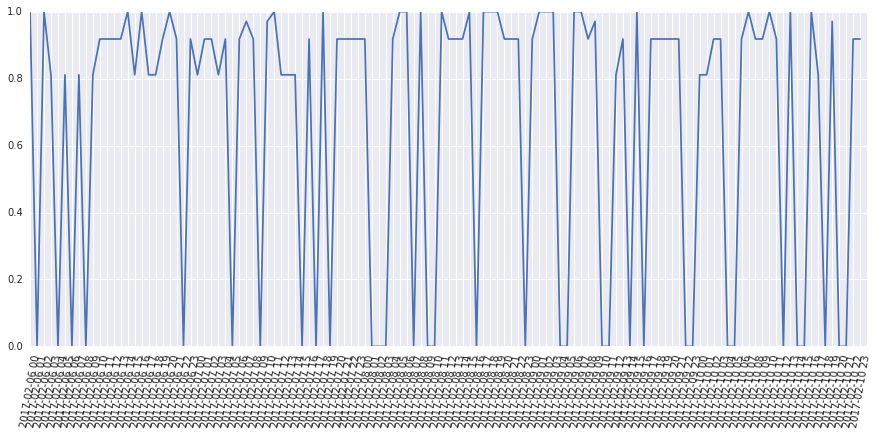

In [53]:
import matplotlib.pyplot as pplt
pplt.plot(calc_ent3['In_degree_entropy'])
pplt.xticks(range(len(calc_ent3['dst_addr_datehour_group'])),calc_ent3['dst_addr_datehour_group'])
pplt.xticks(rotation=80)
#pplt.autoscale(enable=True, axis='x', tight=None)
pplt.show()

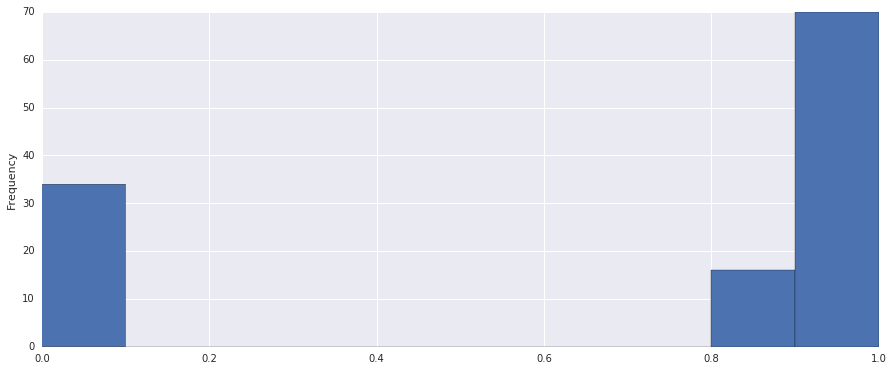

In [54]:
hist_plot = calc_ent3['In_degree_entropy'].plot.hist()

In [56]:
##### Run a correlation to see the relationship between calc_ents indicator features
##### All correlations are statistically significant 
corr1 = pearsonr(calc_ent3['dst_addr'],calc_ent3['unq_src_addr_cnt'])
corr2 = pearsonr(calc_ent3['dst_addr'],calc_ent3['In_degree_entropy'])
corr3 = pearsonr(calc_ent3['unq_src_addr_cnt'],calc_ent3['In_degree_entropy'])
print("feature correlation = ",corr1)
print("dst_addr_cnt x Entropy = ", corr2)
print("unq_src_addr_cnt x Entropy = ", corr3)

feature correlation =  (0.29406050716815685, 0.0011143448718963082)
dst_addr_cnt x Entropy =  (0.35815309882951812, 5.9099272399508499e-05)
unq_src_addr_cnt x Entropy =  (0.78846290330778757, 1.1487989791575519e-26)


In [64]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Create the various feature arrays (1,5,6 for x and 7 for y)
x1 = calc_ent3[['dst_addr']]
x2 = calc_ent3['unq_dst_host_count'] * calc_ent3['dst_addr']
x2 = x2.values.reshape(-1,1)
x3 = calc_ent3['unq_src_addr_cnt'] * calc_ent3['dst_addr']
x3 = x3.values.reshape(-1,1)
y = calc_ent3['In_degree_entropy']

In [66]:
x3

array([[  8.],
       [  2.],
       [  8.],
       [  8.],
       [  3.],
       [  8.],
       [  4.],
       [  8.],
       [  6.],
       [  8.],
       [  6.],
       [  6.],
       [  6.],
       [  6.],
       [  8.],
       [  8.],
       [  8.],
       [  8.],
       [  8.],
       [  6.],
       [  8.],
       [  6.],
       [  3.],
       [  6.],
       [  8.],
       [  6.],
       [  6.],
       [  8.],
       [  6.],
       [  4.],
       [  6.],
       [ 10.],
       [  6.],
       [  4.],
       [ 10.],
       [  8.],
       [  8.],
       [  8.],
       [  8.],
       [  6.],
       [  6.],
       [  6.],
       [  8.],
       [  3.],
       [  6.],
       [  6.],
       [  6.],
       [  6.],
       [  6.],
       [  3.],
       [  2.],
       [  2.],
       [  6.],
       [  4.],
       [  4.],
       [  2.],
       [  4.],
       [  3.],
       [  2.],
       [  4.],
       [  6.],
       [  6.],
       [  6.],
       [  4.],
       [  3.],
       [  4.],
       [  

Coefficients: 
 [ 0.18001878]
Mean squared error: 0.15
Variance score: 0.13


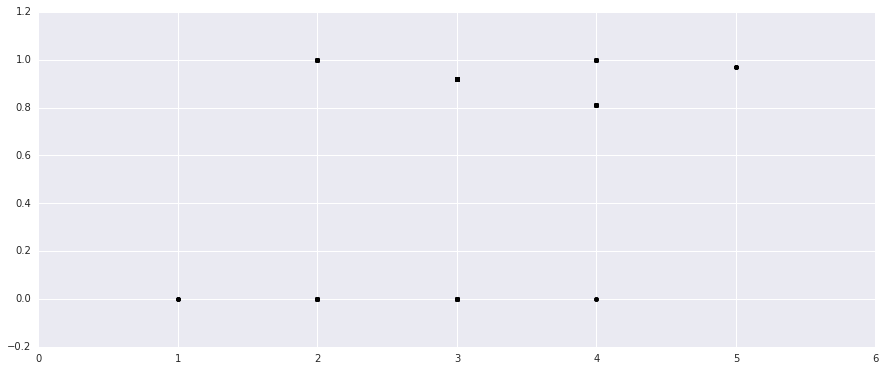

Coefficients: 
 [ 0.1410023]
Mean squared error: 0.07
Variance score: 0.58


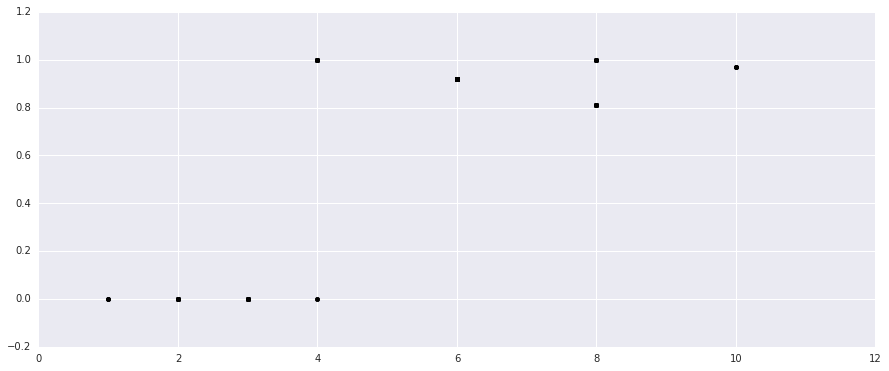

Coefficients: 
 [ 0.13135427]
Mean squared error: 0.10
Variance score: 0.44


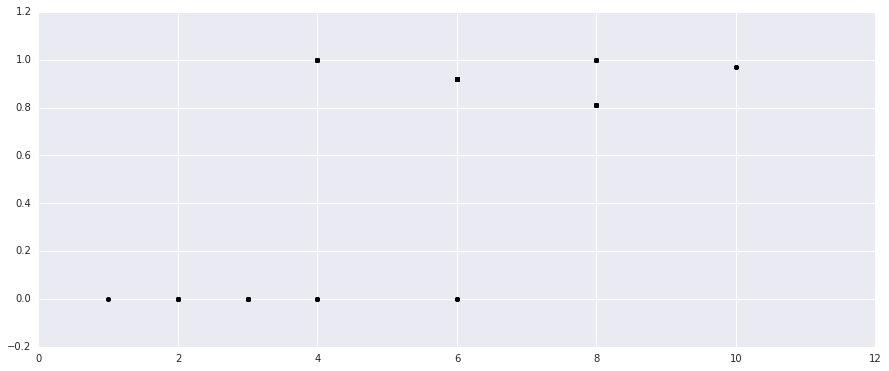

In [67]:
# Fit the Regression Model using the arrays created above
def regression_plots(feature_array):
  regr.fit(feature_array, y)

  # The coefficients
  print('Coefficients: \n', regr.coef_)
  # The mean squared error
  print("Mean squared error: %.2f"
      % np.mean((regr.predict(feature_array) - y) ** 2))
  # Explained variance score: 1 is perfect prediction
  print('Variance score: %.2f' % regr.score(feature_array, y))

  # Plot outputs
  plt.scatter(feature_array, y,  color='black')
  #plt.plot(x1, regr.predict(feature_array), color='blue',
  #       linewidth=3)


  plt.show()
  
regression_plots(x1)
regression_plots(x2)
regression_plots(x3)

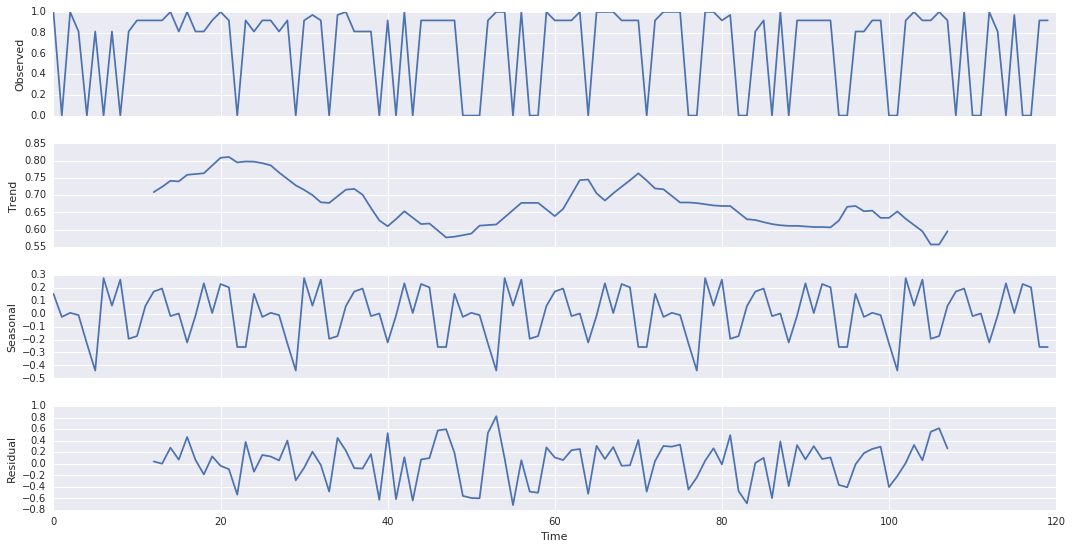

In [68]:
decomposition = seasonal_decompose(calc_ent3.In_degree_entropy.values, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [69]:
calc_ent3.index = calc_ent3['date_hour']
type(calc_ent2['date_hour'])

pandas.core.series.Series

In [70]:
model=ARIMA(calc_ent3['In_degree_entropy'],(1,0,0))    ## The endogenous variable needs to be type Float or you get a cast error
model_fit = model.fit()       # fit is a Function
model_fitted = model_fit.fittedvalues    # fittedvalues is a Series
print(model_fit.summary())
print(model_fitted)

                              ARMA Model Results                              
Dep. Variable:      In_degree_entropy   No. Observations:                  120
Model:                     ARMA(1, 0)   Log Likelihood                 -66.145
Method:                       css-mle   S.D. of innovations              0.420
Date:                Mon, 26 Jun 2017   AIC                            138.291
Time:                        17:55:07   BIC                            146.653
Sample:                    02-06-2017   HQIC                           141.687
                         - 02-10-2017                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6624      0.037     17.920      0.000       0.590       0.735
ar.L1.In_degree_entropy    -0.0373      0.091     -0.409      0.684      -0.216       0.142


In [ ]:
def create_unistats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}
  
# These are DataFrames
bytes_dist = dfx2['bytes'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()
bytes_dist = bytes_dist[(bytes_dist['dst_port']==53) ]   # all stats are displayed for just port 53

duration_dist = dfx2['duration_ms'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()